## Read in data and run pca decomposition

In [179]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.load('ephys_ss_PCA.npy')

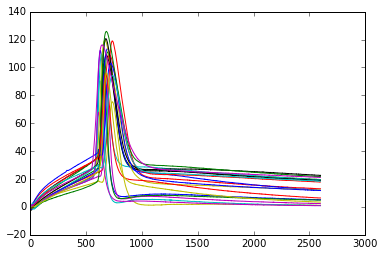

In [180]:
# plot out some traces
r = plt.plot(data[0:200:10,:].T)

In [181]:
# initialized and run decomposition
pca = PCA(20)
pca.fit(data)
decomp = pca.fit_transform(data)
sigma = np.sqrt(pca.explained_variance_)

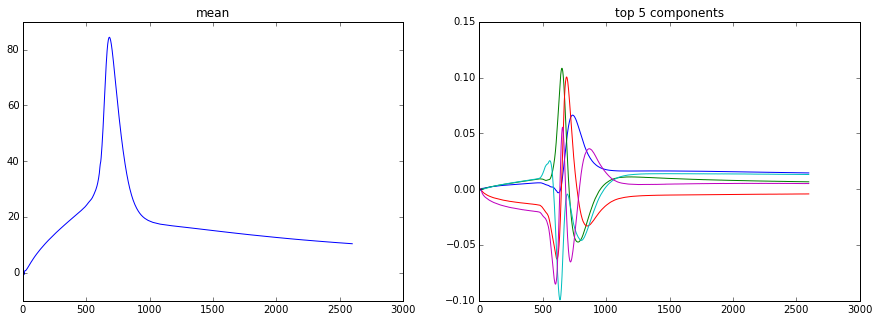

In [182]:
# plot mean and first 5 components
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('mean')
ax2.set_title('top 5 components')
ax1.plot(pca.mean_)
ax2.plot(pca.components_[0:5].T)

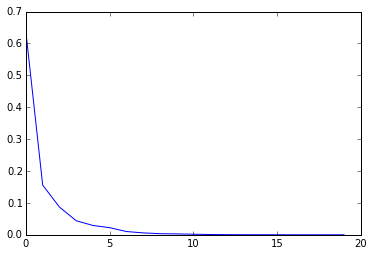

In [183]:
plt.plot(pca.explained_variance_ratio_)

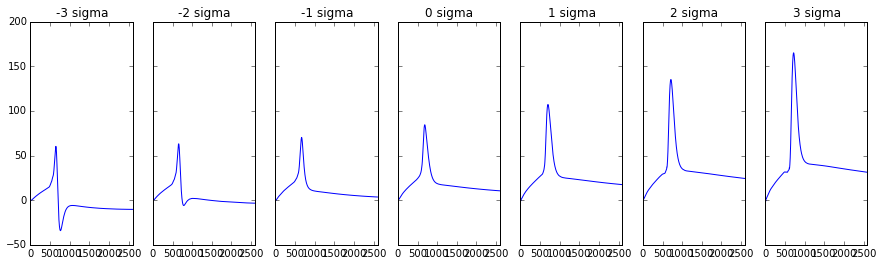

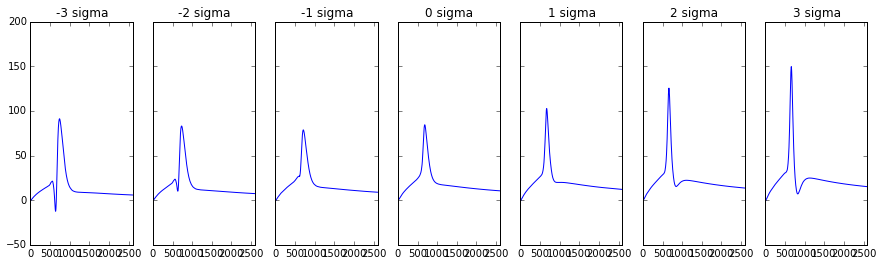

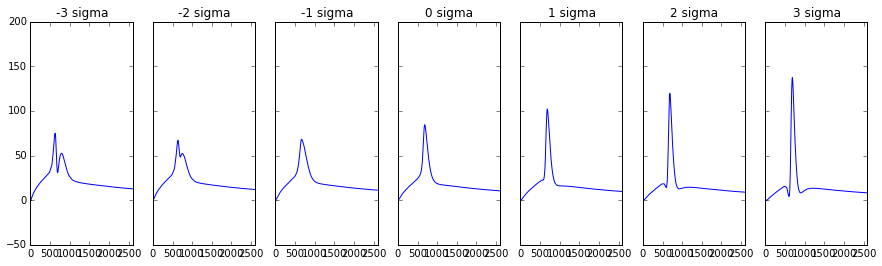

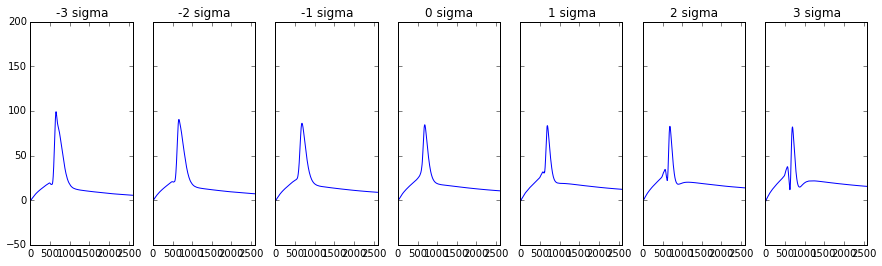

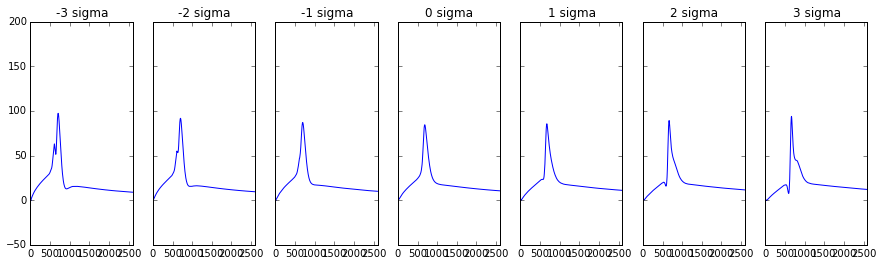

In [393]:
for c in range(5):
    f,ax = plt.subplots(1,7,sharey=True,figsize=(15,4))
    for idx, s in enumerate(range(-3,4)) :
        ax[idx].plot(pca.mean_ + s*sigma[c]*pca.components_[c])
        ax[idx].set_title('%d sigma' % s)
        ax[idx].set_xlim(0,2600)
        ax[idx].set_ylim(-50,200)

## Insert normalized pca components into the pandas table

In [185]:
import pandas as pd

# associate trace data back to specimen_id
trace_df = pd.load('data_frame.h5')
exp_lookup = [e['cell_soma_locations'][0]['specimen_id'] for idx,e in trace_df.iterrows()]

In [186]:
# this dataframe is generated using the "cell_types_dataframe.ipynb" notebook
cells_df = pd.load('../cells_dataframe.h5')

In [188]:
# add top pca components to the cells dataframe
ncomp = 10
for c in range(ncomp):
    cells_df['ephys_ss_%02d' % c] = np.nan
    
start_label = 'ephys_ss_%02d' % 0
end_label = 'ephys_ss_%02d' % (ncomp-1)

In [189]:
for idx, e in enumerate(exp_lookup) :
    cells_df.ix[e, start_label:end_label] = np.divide(decomp[idx,0:ncomp],sigma[0:ncomp])

In [ ]:
# save the dataframe to disk

### TODO

## Plot some graphs

In [227]:
def scatter_with_labels(x,y,label,colors) :
    plt.figure(figsize=(9,9))
    for dtype, color in colors:
        masked = cells_df[cells_df[label] == dtype]
        plt.scatter(masked[x], masked[y], color=color, label=dtype)
    plt.legend(loc='best')
    plt.ylabel(y)
    plt.xlabel(x)

In [383]:
def plot_eigen_spike(cx,cy) :
    f,ax = plt.subplots(4,4,sharex=True,sharey=True,figsize=(9,9))
    for idx, x in enumerate(np.linspace(-1.5,1.5,4)) :
        for idy, y in enumerate(np.linspace(1.5,-1.5,4)) :
            ax[idy,idx].plot(pca.mean_ + x*sigma[cx]*pca.components_[cx] + y*sigma[cy]*pca.components_[cy],color='gray')
            ax[idy,idx].set_xlim(0,2600)
            ax[idy,idx].set_ylim(-30,180)
            ax[idy,idx].axes.get_yaxis().set_visible(False)
            ax[idy,idx].axes.get_xaxis().set_visible(False)
            ax[idy,idx].set_frame_on(False)
            

In [384]:
# map some colors to cre-lines
cre_lines = [
'Rorb-IRES2-Cre',
'Scnn1a-Tg2-Cre',
'Scnn1a-Tg3-Cre',
'Nr5a1-Cre',
'Rbp4-Cre_KL100',
'Ntsr1-Cre',
'Sst-IRES-Cre',
'Pvalb-IRES-Cre',
'Htr3a-Cre_NO152',
'Gad2-IRES-Cre']
cre_colors = [
'darksage',
'green',
'mediumaquamarine',
'c',
'dodgerblue',
'blue',
'magenta',
'firebrick',
'r']

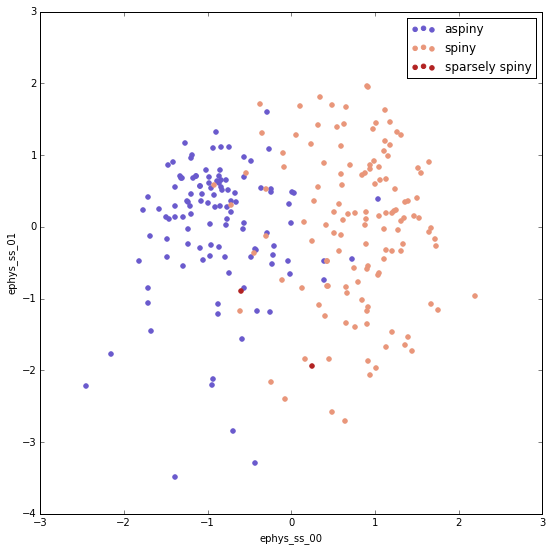

In [385]:
scatter_with_labels('ephys_ss_00','ephys_ss_01','dendrite_type',
                     zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))

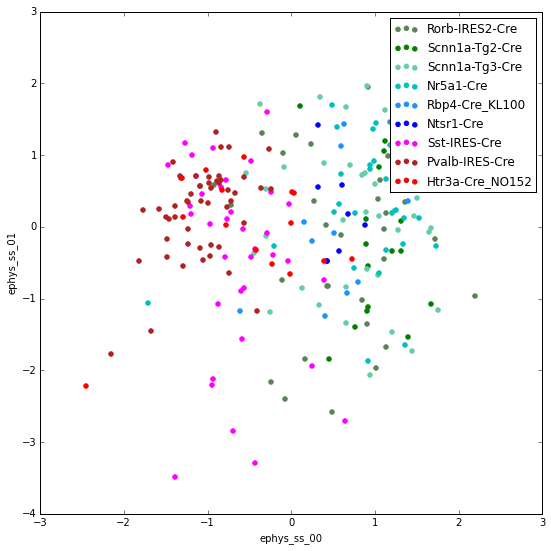

In [386]:
scatter_with_labels('ephys_ss_00','ephys_ss_01','mouse_line', zip(cre_lines,cre_colors))

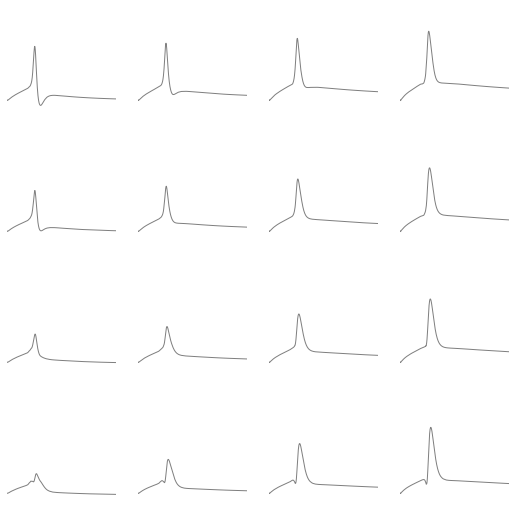

In [387]:
plot_eigen_spike(0,1)

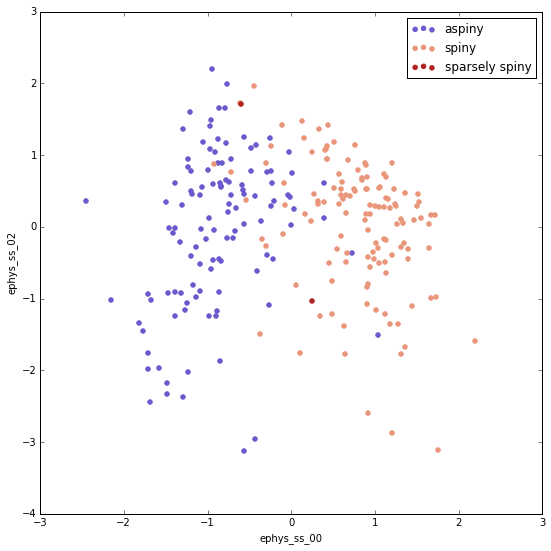

In [388]:
scatter_with_labels('ephys_ss_00','ephys_ss_02','dendrite_type',
                     zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))

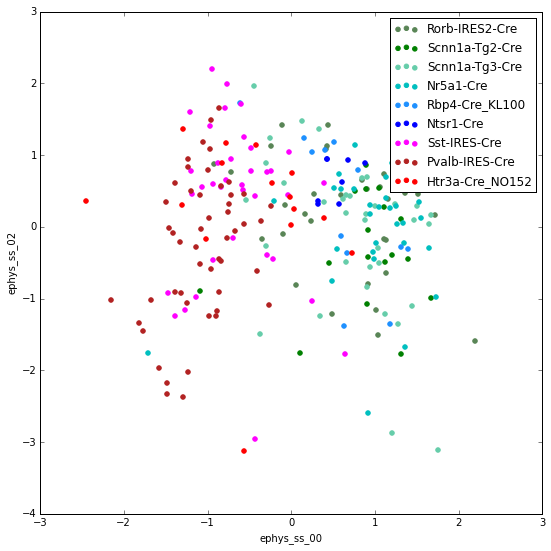

In [389]:
scatter_with_labels('ephys_ss_00','ephys_ss_02','mouse_line', zip(cre_lines,cre_colors))

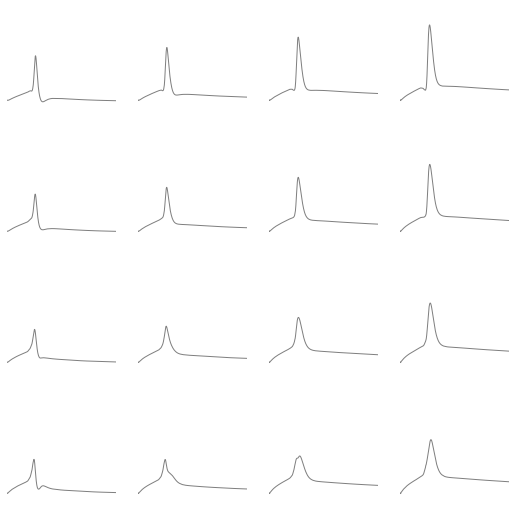

In [390]:
plot_eigen_spike(0,2)

## Correlation between each normalized components and computed ephys features

In [328]:
# compute correlation between all columns
correlation = cells_df.corr(method='spearman')

In [392]:
ephys_corr = correlation.ix['tau':'adaptation','ephys_ss_00':'ephys_ss_09']

for c in range(5) :
    f = 'ephys_ss_%02d' % c
    mask = (np.fabs(ephys_corr[f]) > 0.5)
    srt = ephys_corr[mask].sort(f,ascending=False)
    print srt[f]
    print '\n'

upstroke_downstroke_ratio_short_square    0.808451
upstroke_downstroke_ratio_long_square     0.773576
upstroke_downstroke_ratio_ramp            0.765968
fast_trough_v_short_square                0.765782
fast_trough_v_long_square                 0.727606
peak_v_ramp                               0.700904
latency                                   0.684484
threshold_i_short_square                  0.678128
avg_isi                                   0.650809
peak_v_long_square                        0.641620
fast_trough_v_ramp                        0.639408
peak_v_short_square                       0.610621
fast_trough_t_short_square                0.569212
peak_t_short_square                       0.550445
tau                                       0.523446
trough_t_long_square                      0.502278
f_i_curve_slope                          -0.514171
Name: ephys_ss_00, dtype: float64


threshold_t_short_square   -0.503959
peak_t_short_square        -0.538850
Name: ephys_ss_01, dtyp

## Cluster cells using normalized components

In [491]:
from sklearn.cluster import AffinityPropagation
exp_mask = ~np.isnan(cells_df['ephys_ss_00'])
masked = cells_df[exp_mask]
cluster_input = masked.ix[:,'ephys_ss_00':'ephys_ss_09'].as_matrix()

In [492]:
affinity = AffinityPropagation().fit(cluster_input)

In [493]:
# put labels back into cells_df
cells_df['ephys_cluster'] = np.nan

In [494]:
for a in zip(masked.index,affinity.labels_) :
    cells_df.ix[a[0],'ephys_cluster'] = a[1]

In [497]:
len(np.unique(affinity.labels_))

32

## Things to try

Plot top 3 pca in 3D